In [1]:
import numpy as np
from pint import UnitRegistry
import math
ureg = UnitRegistry()
np.set_printoptions(precision=4)
import sys
sys.path.append('/Users/Lampe/PyScripts/surgeAnalysis')
# import SurgeFunc as sf

## Function for the Evaluation of the Darcy-Weisbach Friction Factor

In [2]:
class FrictionFact():
    
    def __init__(self, flowRate, dynVisc, spGrav, ID, roughness, units = 0):
        """
            General class for calculating the Darcy-Weisbach Friction Factor.
            
            All calculations will be performed in consisten SI units.  
            Therefore, if units are input in US terms (units=0), they will be converted to SI for calculation.
            
            Units for Input (must maintain a constant system of units):
            
                      |   DESCRIPTION      | US     | SI   |
            units     |system of units     | =0     | !=0  |
            ------------------------------------------------
            flowRate  |volumetric flow rate|gal/min |m3/hr |
            dynVisc   |dynamic viscosity   |cP      |Pa-s  |
            spGrav    |specific gravity    |none    |none  |
            ID        |internal diameter   |inch    |m     |
            roughness |pipe roughness      |inch    |m     |
            length    |length of flow      |feet    |m     |

        """
        self.Q = flowRate
        self.mu = dynVisc
        self.sg = spGrav
        self.ID = ID
        self.roughness = roughness
        self.units = units
        
        
    def CheckUnits(self):
        """
        Calculations will all be performed in SI units; therefore, this method converts from US to SI units
        """
        self.rho = self.sg * 1000 #kg/m3
        if self.units == 0:
            #convert from US to SI units
            self.Q = self.Q *3.7853/1000. / 60. # m3/sec
            self.ID = self.ID * 2.54 / 100. # m
            area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / area # m/sec
            self.mu = self.mu * 10**-3 # Pa-s
            self.roughness = self.roughness * 2.54 / 100. # m
            textOut = "Input Was US Units"
        else:
            #convert to consistent SI units
            self.Q = self.Q / 3600. # m3/sec
            area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / area # m/sec
            textOut = "Input Was SI Units"
        return self
    
    def Re(self):
        """
        Calculates Reynolds Number
         - this method may be called to check the Reynolds Number
        """
        self.Re = self.rho * self.v * self.ID / self.mu
        return self
        
    def FricFact(self):
        """
        Function to obtain the Darcy-Weisbach friction factor:
            Laminar Flow (Re <= 2000) -> Poiseuille's relationship
            Turbulent Flow (Re > 2000) -> evaluate the colebrrok-white equation 

        Input:
        -------------------------------------------------
        Re (required): reynolds number (dimensionless)
        d  (required): hydraulic diameter (length)
        epsilon (required): conduit roughness (length)

        Output:
        -------------------------------------------------
        f: darcy-weisbach friction factor (dimensionless)
        """
        if self.Re <= 2000.:
            f = self.Re / 64.
        else:
            sqrt_f = 10.0 # initial guess
            loop_max = 20 # max. number of loops
            inc = 1 # increment count
            res = 10.0 # initial value

            while res > 10**-8 and inc < loop_max:
                LHS = -2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * sqrt_f))
                res = (LHS - 1./sqrt_f)**2 #squared error
                sqrt_f = 1./LHS
                inc = inc + 1
            f = sqrt_f**2

            if inc == loop_max:
                outText = "Friction Factor Did NOT Converge! Printed Value Should ~= 1.0"
                print(outText)
                print(-2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * f**0.5)) * f**0.5)
                
        self.f = f
        return self
    
    def Calc(self):
        """
        This method must be called to obtain any need parameters
        """
        self.CheckUnits()
        self.Re()
        self.FricFact()
        return self

In [12]:
class SS_DeltaH():
    
    def __init__(self, flowRate, dynVisc, spGrav, ID, roughness, length, units = 0):
        """
            General class for calculating the Darcy-Weisbach Friction Factor.
            
            All calculations will be performed in consisten SI units.  
            Therefore, if units are input in US terms (units=0), they will be converted to SI for calculation.
            
            Units for Input (must maintain a constant system of units):
            
                      |   DESCRIPTION      | US     | SI   |
            units     |system of units     | =0     | !=0  |
            ------------------------------------------------
            flowRate  |volumetric flow rate|gal/min |m3/hr |
            dynVisc   |dynamic viscosity   |cP      |Pa-s  |
            spGrav    |specific gravity    |none    |none  |
            ID        |internal diameter   |inch    |m     |
            roughness |pipe roughness      |inch    |m     |
            length    |length of flow      |feet    |m     |

        """
        self.Q = flowRate
        self.mu = dynVisc
        self.sg = spGrav
        self.ID = ID
        self.roughness = roughness
        self.L = length
        self.units = units
        
        
    def CheckUnits(self):
        """
        Calculations will all be performed in SI units; therefore, this method converts from US to SI units
        """
        self.rho = self.sg * 1000 #kg/m3
        if self.units == 0:
            #convert from US to SI units
            self.Q = self.Q *3.7853/1000. / 60. # m3/sec
            self.ID = self.ID * 2.54 / 100. # m
            self.area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / self.area # m/sec
            self.mu = self.mu * 10**-3 # Pa-s
            self.roughness = self.roughness * 2.54 / 100. # m
            textOut = "Input Was US Units"
        else:
            #convert to consistent SI units
            self.Q = self.Q / 3600. # m3/sec
            self.area = np.pi * self.ID **2 / 4.# m2
            self.v = self.Q / self.area # m/sec
            textOut = "Input Was SI Units"
        return self
    
    def Re(self):
        """
        Calculates Reynolds Number
         - this method may be called to check the Reynolds Number
        """
        self.Re = self.rho * self.v * self.ID / self.mu
        return self
        
    def FricFact(self):
        """
        Function to obtain the Darcy-Weisbach friction factor:
            Laminar Flow (Re <= 2000) -> Poiseuille's relationship
            Turbulent Flow (Re > 2000) -> evaluate the colebrrok-white equation 

        Input:
        -------------------------------------------------
        Re (required): reynolds number (dimensionless)
        d  (required): hydraulic diameter (length)
        epsilon (required): conduit roughness (length)

        Output:
        -------------------------------------------------
        f: darcy-weisbach friction factor (dimensionless)
        """
        if self.Re <= 2000.:
            f = self.Re / 64.
        else:
            sqrt_f = 10.0 # initial guess
            loop_max = 20 # max. number of loops
            inc = 1 # increment count
            res = 10.0 # initial value

            while res > 10**-8 and inc < loop_max:
                LHS = -2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * sqrt_f))
                res = (LHS - 1./sqrt_f)**2 #squared error
                sqrt_f = 1./LHS
                inc = inc + 1
            f = sqrt_f**2

            if inc == loop_max:
                outText = "Friction Factor Did NOT Converge! Printed Value Should ~= 1.0"
                print(outText)
                print(-2.0 * np.log10(self.roughness / (3.7 * self.ID) + 2.51 / (self.Re * f**0.5)) * f**0.5)
                
        self.f = f
        return self
    
    def HeadLoss(self):
        """
        Calculates the change in piezometric head for steady-state flow
        accounts for head loss resulting from:
            -friction
            -change in elevation
        """
        g = 9.806 #m/s2
        dh_m = -self.f * (self.Q /3600.)**2 * self.L / (2 * self.ID * self.area**2*g) - self.L
        dp_Pa = self.rho * g * dh_m
        
        if self.units == 0:
            """
            Calculate head loss: feet
            Calculate pressure loss: psi
            """
            self.dh = dh_m / 0.3048 # feet
            self.dp = dp_Pa * 1.4504 * 10**-4 # psi
        else:
            """
            Calculate head loss: meter
            Calculate pressure loss: MPa
            """
            self.dh = dh_m
            self.dp = dp_Pa / 10**6
                    
    def Calc(self):
        """
        This method must be called to obtain any need parameters
        """
        self.CheckUnits()
        self.Re()
        self.FricFact()
        self.HeadLoss()
        return self

In [20]:
q = 0.15707963267948968*3600# m3/hr
q = q * 7.48052 / (.3048**3  *60) # gpm

mu = 8.90 * 10**-4 # Pa-s, N-s/m2
mu = mu * 10 **3 # cP

sg = 1.2 #rho = 1200 # kg/m3

d = 0.2 # m
d = d* 12./.3048 # inch

rough = 0.005 # roughness
rough = rough * 12./.3048 # inch

L = 1000. # conduit lenth (m)
L = L / .3048 # feet

# friction = FrictionFact(q, mu, sg, d, rough, L, units=0)

# g = 9.81 #m/s2   
# h_f = fric_fact*(l/d)*(v**2/2*g)
# dp = rho * g * h_f

In [25]:
f = FrictionFact(q, mu, sg, d, rough, units=0).Calc().f
Re = FrictionFact(q, mu, sg, d, rough, units=0).Calc().Re

print(f)
print(Re)

0.0530781543884
12056162080.9


# Calculate Steady-State Pressure Distribution

In [26]:
z =  np.linspace(0, 1000, 101) # m
q = 0.15707963267948968*3600# m3/hr
# q = q * 7.48052 / (.3048**3  *60) # gpm

mu = 8.90 * 10**-4 # Pa-s, N-s/m2
# mu = mu * 10 **3 # cP

sg = 1.2 #rho = 1200 # kg/m3

d = 0.2 # m
# d = d* 12./.3048 # inch

rough = 0.005 # roughness
# rough = rough * 12./.3048 # inch

L = 1000. # conduit lenth (m)
# L = L / .3048 # feet

f = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().f
Re = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().Re
dh = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().dh
dp = SS_DeltaH(q, mu, sg, d, rough, L, units=1).Calc().dp
print(f)
print(Re)
print(dh)
print(dp)

0.0531035435355
1348314.60674
-1000.00002612
-11.7672003073


In [40]:
z = np.linspace(0., 1000, 101)
h = np.zeros(len(z)) # head (m)
p = np.zeros(len(z)) # pressure (Pa)
dp = np.zeros(len(z)) # pressure (Pa)

p0 = 20 # MPa
dp = SS_DeltaH(q, mu, sg, d, rough, z, units=1).Calc().dp
p = p0 + dp

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

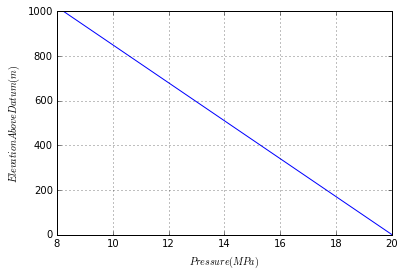

In [46]:
plt.plot(p,z)
plt.xlabel('$Pressure (MPa)$')
plt.ylabel('$Elevation Above Datum (m)$')
plt.grid()